# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


In [ ]:
# import os

# os.chdir("/content/drive/MyDrive/GAN_747")


In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


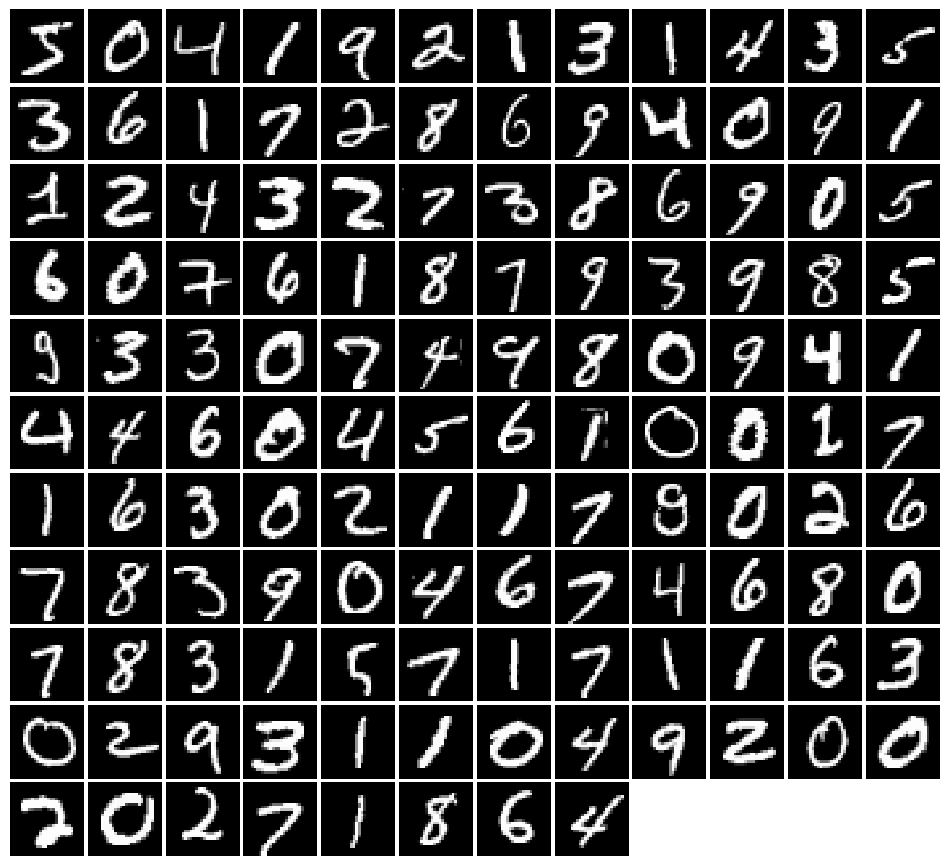

In [34]:
NOISE_DIM = 100
batch_size = 128
img_size = 28

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs_iter = loader_train.__iter__()
imgs = next(imgs_iter)[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [7]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [8]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 0.4925, G:0.6557


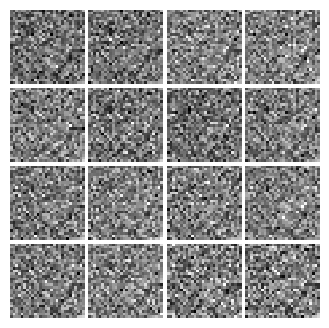


Iter: 250, D: 0.4046, G:0.9714


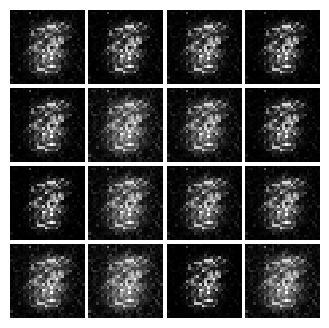


EPOCH:  2
Iter: 500, D: 0.3087, G:0.8158


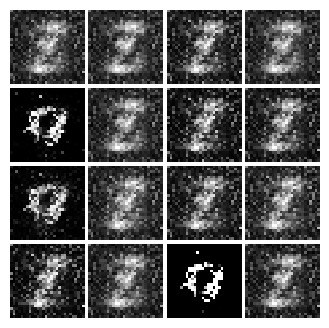


Iter: 750, D: 0.3832, G:0.6909


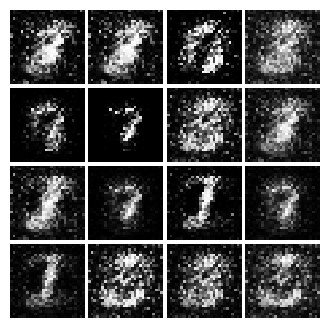


EPOCH:  3
Iter: 1000, D: 0.3476, G:0.9287


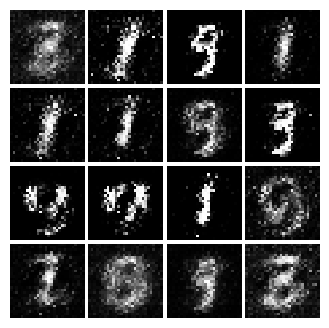


Iter: 1250, D: 0.3595, G:0.6532


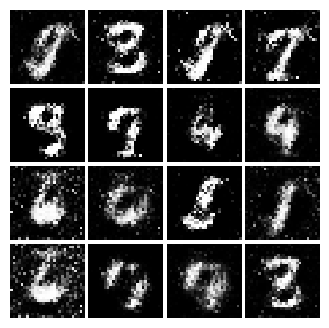


EPOCH:  4
Iter: 1500, D: 0.3673, G:0.7075


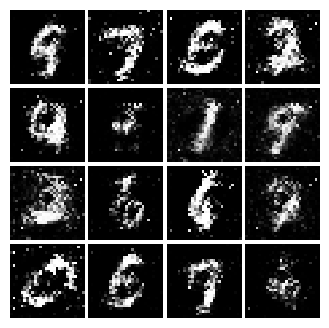


Iter: 1750, D: 0.4113, G:0.6777


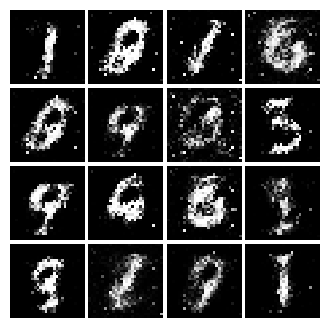


EPOCH:  5
Iter: 2000, D: 0.3965, G:0.6024


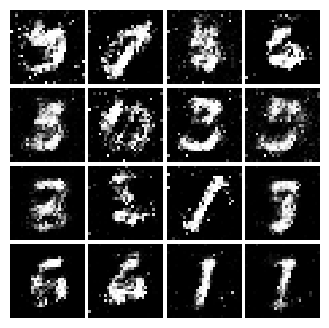


Iter: 2250, D: 0.4289, G:0.664


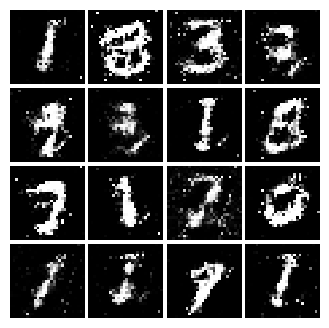


EPOCH:  6
Iter: 2500, D: 0.4455, G:0.5778


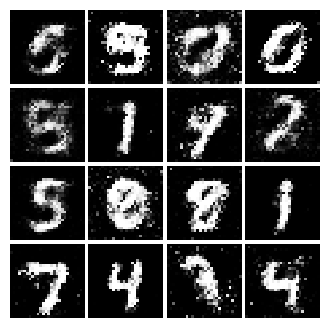


Iter: 2750, D: 0.4359, G:0.5583


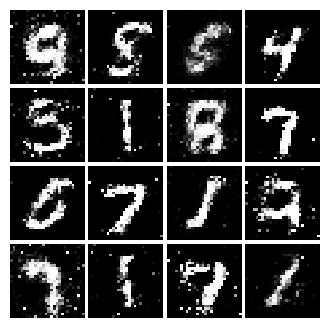


EPOCH:  7
Iter: 3000, D: 0.402, G:0.9396


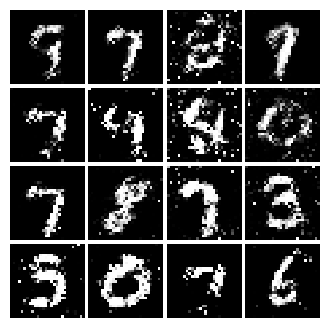


Iter: 3250, D: 0.3947, G:0.8913


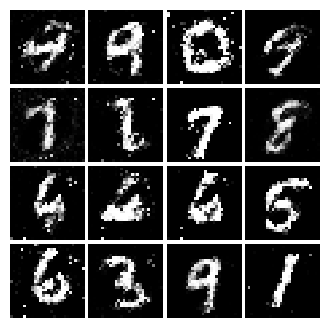


EPOCH:  8
Iter: 3500, D: 0.4825, G:0.5103


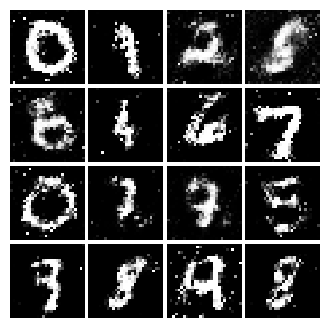


EPOCH:  9
Iter: 3750, D: 0.4448, G:0.506


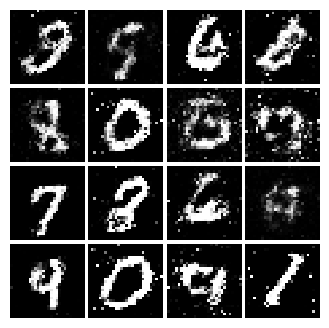


Iter: 4000, D: 0.4582, G:0.5283


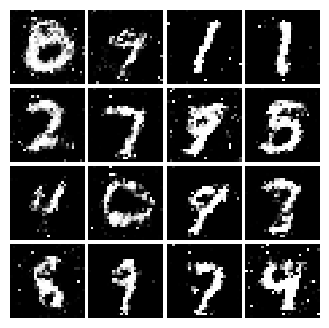


EPOCH:  10
Iter: 4250, D: 0.4405, G:0.6059


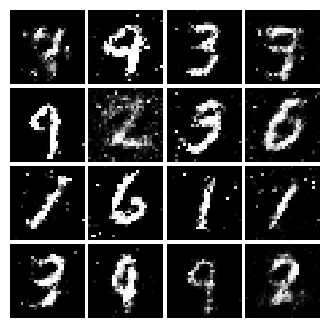


Iter: 4500, D: 0.4395, G:0.5844


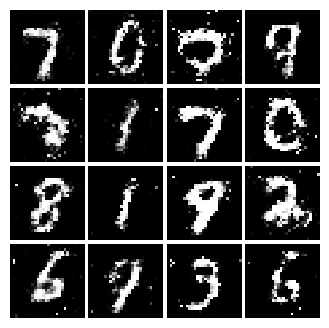

In [82]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device, img_resolution= img_size)

EPOCH:  1
Iter: 0, D: 0.5467, G:0.9296


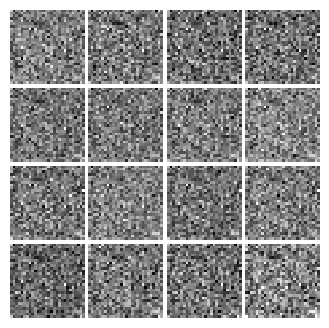


Iter: 250, D: 0.08869, G:0.6743


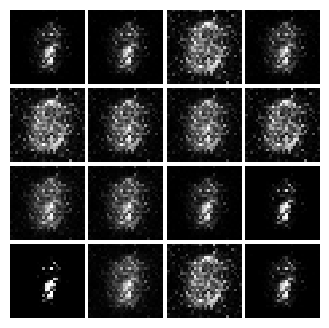


EPOCH:  2
Iter: 500, D: 0.1202, G:0.6646


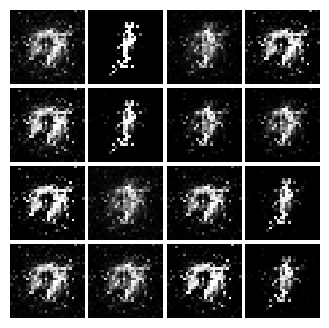


Iter: 750, D: 0.3784, G:0.5338


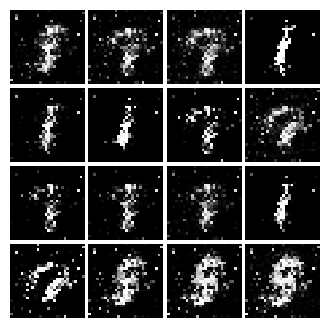


EPOCH:  3
Iter: 1000, D: 0.1529, G:0.455


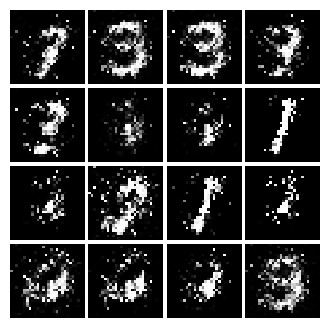


Iter: 1250, D: 0.1804, G:0.4912


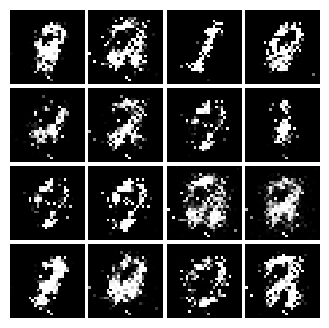


EPOCH:  4
Iter: 1500, D: 0.1772, G:0.466


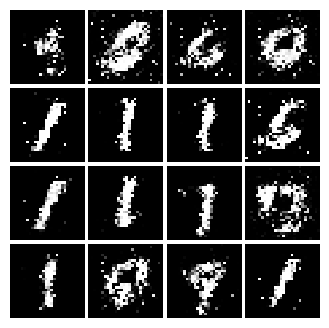


Iter: 1750, D: 0.1968, G:0.4928


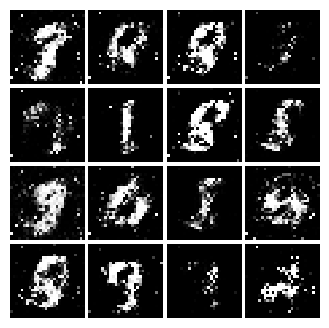


EPOCH:  5
Iter: 2000, D: 0.2097, G:0.3524


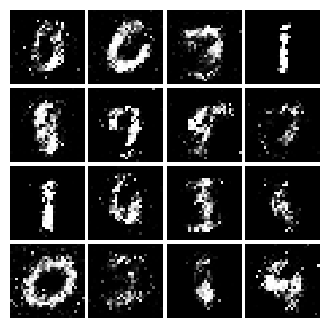


Iter: 2250, D: 0.2434, G:0.3411


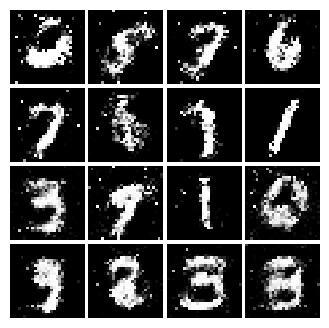


EPOCH:  6
Iter: 2500, D: 0.2465, G:0.3843


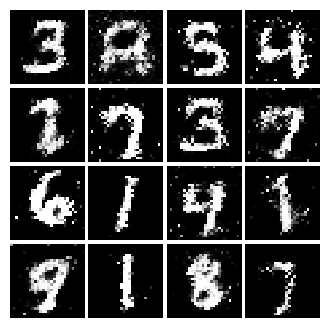


Iter: 2750, D: 0.226, G:0.3308


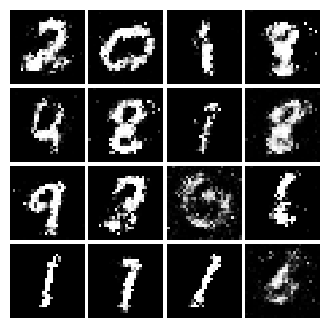


EPOCH:  7
Iter: 3000, D: 0.2118, G:0.3647


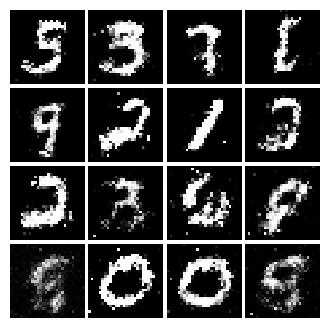


Iter: 3250, D: 0.1912, G:0.3782


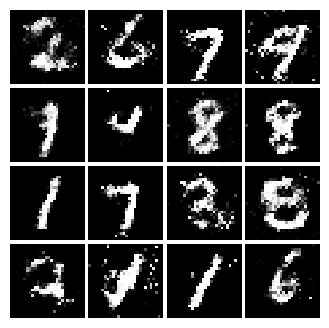


EPOCH:  8
Iter: 3500, D: 0.2149, G:0.3335


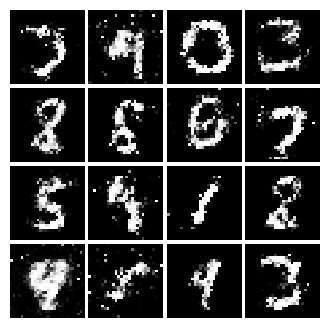


EPOCH:  9
Iter: 3750, D: 0.2061, G:0.3958


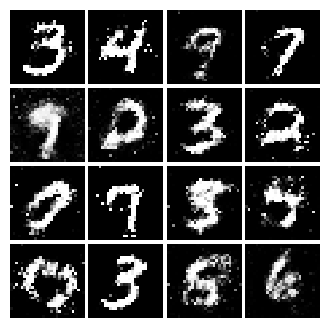


Iter: 4000, D: 0.2323, G:0.3539


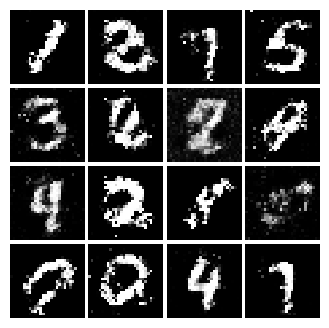


EPOCH:  10
Iter: 4250, D: 0.2555, G:0.4122


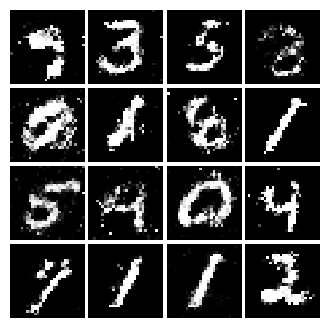


Iter: 4500, D: 0.2426, G:0.3531


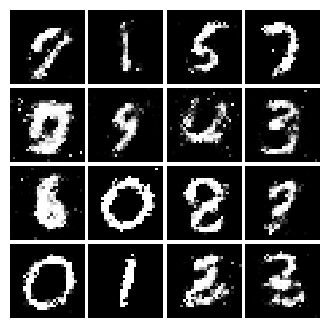

In [83]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device, img_resolution= img_size)